<a href="https://colab.research.google.com/github/dagarcsot/CuatroEnRalla/blob/main/Proyecto_3_1_Clasificador_Binario.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- *Nombre Alumno/a*: Daniel García Soto
- *Asignatura*: Ingeniería del Conocimiento
- *Curso*: 2024/2025
- *Profesor*: Fco. Javier Martínez de Pisón
- Universidad de La Rioja

# Proyecto 3.A. Parte 1. Diseño de DSS en Empresa de Ventas On-Line: Clasificador Binario de la Clase 2

Vamos a desarrollar clasificadores trabajando con la base de datos de la competicion de Kaggle [Otto Group Product Classification](https://www.kaggle.com/c/otto-group-product-classification-challenge).

Otto Group es una de las mayores multinacionales de venta de comercio electrónico con empresas subsidiarias en más de 20 países del mundo. Cada día, venden millones de productos por todo el mundo incrementando continuamente la oferta con miles de productos nuevos.

Debido a la enorme cantidad de productos que se incluyen diariamente, **la empresa necesita tener un buen modelo predictivo que le ayude a clasificar cada nuevo producto en nueve grandes grupos**. Este modelo permitirá a la empresa ser mucho más eficiente en la realización de futuros trabajos como: análisis de mercado, análisis de clientes, diseño de ofertas, análisis de ventas, etc.

![](https://github.com/INGCON2425/proyecto3a-dagarcsot/blob/main/otto.jpg?raw=1)

En este proyecto vamos a aprender a desarrollar modelos clasificadores útiles para la toma de decisiones empresariales. En particular, el objetivo es buscar buenos modelos clasificadores capaces de identificar ante un nuevo producto y una serie de características que lo describe, **a qué familia pertenece**.

Primero desarrollaremos modelos binarios y después modelos multiclase. A aprenderemos cómo realizar el ajuste de los hiperparámetros de modelos y combinarlos en modelos *Ensemble*.

Primero, vamos a instalar algunas librerías útiles para la práctica:

In [2]:
# Importamos paquetes basicos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
# from tqdm.notebook import tqdm
from tqdm.notebook import tqdm

import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import log_loss, cohen_kappa_score, accuracy_score, f1_score, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression

# %matplotlib inline
plt.style.use('ggplot')
# Elimina la limitación en visualización del numero de columnas
pd.set_option('display.max_columns', None)
%matplotlib inline

## Cargamos la Base de Datos

In [3]:
!wget https://github.com/IC1920/Datasets/raw/master/train.zip -O train.zip
!wget https://github.com/IC1920/Datasets/raw/master/test.zip -O test.zip
!unzip -o train.zip
!unzip -o test.zip

--2025-05-10 20:11:18--  https://github.com/IC1920/Datasets/raw/master/train.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IC1920/Datasets/master/train.zip [following]
--2025-05-10 20:11:19--  https://raw.githubusercontent.com/IC1920/Datasets/master/train.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1655239 (1.6M) [application/zip]
Saving to: ‘train.zip’

train.zip           100%[===================>]   1.58M  --.-KB/s    in 0.07s   

2025-05-10 20:11:19 (24.1 MB/s) - ‘train.zip’ saved [1655239/1655239]

--2025-05-10 20:11:19--  https://github.com/IC1920/Datasets/raw/master/test.zip

Para reducir los tiempos de entrenamiento y, por fines didácticos, **vamos a crear tres bases de datos a partir de la base de datos de entrenamiento original**: una de entrenamiento, otra de validación para ajustar los hiperparámetros y una final de testeo para verificar el grado de generalización del modelo elegido. Las mismas se van a realizar mediante **muestreo estratificado**, es decir, el target de cada base de datos va a tener la misma distribución de clases. Lo ideal sería utilizar un alto porcentaje de la BD para entrenar (por ejemplo un 80%) o usar validación cruzada (incluso repetida), pero con fines didácticos y para acelerar el proceso de entrenamiento vamos a reducir el tamaño de la base de datos de entrenamiento. Nota: en este caso, los modelos seguramente mejorarán si se entrenan con más datos...

La base de datos original está disponible en https://www.kaggle.com/c/otto-group-product-classification-challenge, con más de 65.000 instancias. Es importante destacar que las variables han sido anonimizadas por la empresa y no se dispone de su descripción real.

---

**Para profundizar en los conceptos ver los siguientes videos**:

- *Stratified Sampling to Split Train Test Validation Data | Machine Learning*: https://www.youtube.com/watch?v=ixBbAZDS7TU
- *Sampling: Population vs. Sample, Random Sampling, Stratified Sampling*: https://www.youtube.com/watch?v=r-rFO_2NsgI

---

In [4]:
# Leemos los archivos
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
print(df_train.shape, df_test.shape)

# Cogemos las características de entrada
features = ['feat_'+str(i) for i in np.arange(1,94)]
# Definimos cual es el target
target = 'target'

(61878, 95) (144368, 94)


In [5]:
df_train.columns

Index(['id', 'feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6',
       'feat_7', 'feat_8', 'feat_9', 'feat_10', 'feat_11', 'feat_12',
       'feat_13', 'feat_14', 'feat_15', 'feat_16', 'feat_17', 'feat_18',
       'feat_19', 'feat_20', 'feat_21', 'feat_22', 'feat_23', 'feat_24',
       'feat_25', 'feat_26', 'feat_27', 'feat_28', 'feat_29', 'feat_30',
       'feat_31', 'feat_32', 'feat_33', 'feat_34', 'feat_35', 'feat_36',
       'feat_37', 'feat_38', 'feat_39', 'feat_40', 'feat_41', 'feat_42',
       'feat_43', 'feat_44', 'feat_45', 'feat_46', 'feat_47', 'feat_48',
       'feat_49', 'feat_50', 'feat_51', 'feat_52', 'feat_53', 'feat_54',
       'feat_55', 'feat_56', 'feat_57', 'feat_58', 'feat_59', 'feat_60',
       'feat_61', 'feat_62', 'feat_63', 'feat_64', 'feat_65', 'feat_66',
       'feat_67', 'feat_68', 'feat_69', 'feat_70', 'feat_71', 'feat_72',
       'feat_73', 'feat_74', 'feat_75', 'feat_76', 'feat_77', 'feat_78',
       'feat_79', 'feat_80', 'feat_81', 'feat_82', 'fe

In [6]:
# Realizamos un Muestreo Estratificado con 10 folds
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
# Convertimos a números las clases (0 a 8)
df_train['target_num'] = df_train['target'].map(dict(zip(df_train.target.unique(),np.arange(len(df_train.target.unique())))))
df_train['kfold'] = 0
for nfold, (_, fold_index) in enumerate(skf.split(df_train, df_train.target)):
    df_train.loc[fold_index, 'kfold'] = nfold

df_train_reduc = df_train[df_train['kfold']<4].reset_index(drop=True)    # Cogemos los 4 primeros folds para entrenamiento
df_valid_reduc = df_train[df_train['kfold'].isin([4,5,6])].reset_index(drop=True) # Los siguientes tres para validación
df_test_reduc = df_train[df_train['kfold']>6].reset_index(drop=True)    # Los últimos 7, 8 y 9 para testeo
print(df_train_reduc.shape, df_valid_reduc.shape, df_test_reduc.shape)

(24752, 97) (18564, 97) (18562, 97)


## AED Básico

La base de datos está anonimizada por la empresa y ya preprocesada por lo que realizaremos un AED muy sencillo.

In [7]:
df_train_reduc.sample(5)

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18,feat_19,feat_20,feat_21,feat_22,feat_23,feat_24,feat_25,feat_26,feat_27,feat_28,feat_29,feat_30,feat_31,feat_32,feat_33,feat_34,feat_35,feat_36,feat_37,feat_38,feat_39,feat_40,feat_41,feat_42,feat_43,feat_44,feat_45,feat_46,feat_47,feat_48,feat_49,feat_50,feat_51,feat_52,feat_53,feat_54,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,feat_65,feat_66,feat_67,feat_68,feat_69,feat_70,feat_71,feat_72,feat_73,feat_74,feat_75,feat_76,feat_77,feat_78,feat_79,feat_80,feat_81,feat_82,feat_83,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target,target_num,kfold
7168,17922,0,0,0,0,0,0,0,0,0,0,0,0,0,8,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,7,0,0,0,0,0,Class_2,1,3
10760,26888,0,0,0,0,0,0,0,1,0,0,0,0,0,1,3,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,3,0,0,0,1,0,0,0,0,0,0,0,0,6,2,0,4,0,0,0,0,0,Class_4,3,1
16862,42105,0,0,5,1,0,0,0,0,0,0,17,0,0,0,0,2,0,0,0,0,1,0,0,7,0,2,19,1,0,0,0,2,0,0,0,0,0,0,1,0,0,1,0,0,0,5,0,0,0,0,0,0,0,16,0,1,0,8,0,1,3,1,0,1,0,0,1,0,0,0,0,2,2,1,0,0,0,0,0,2,0,0,0,0,1,0,1,0,1,0,1,0,0,Class_6,5,1
11099,27760,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,Class_4,3,1
17016,42505,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,2,2,1,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,Class_6,5,2


In [8]:
np.unique(df_train.dtypes,return_counts=True)

(array([dtype('int64'), dtype('O')], dtype=object), array([96,  1]))

Tenemos, además del 'id' de cada producto, 93 características anónimas del tipo entero 64. Según la descripción de Kaggle los atributos representan el conteo de diferentes eventos.

El *target*, representa 9 clases con la siguiente distribución (la base de datos de testeo lógicamente no tiene *target*).

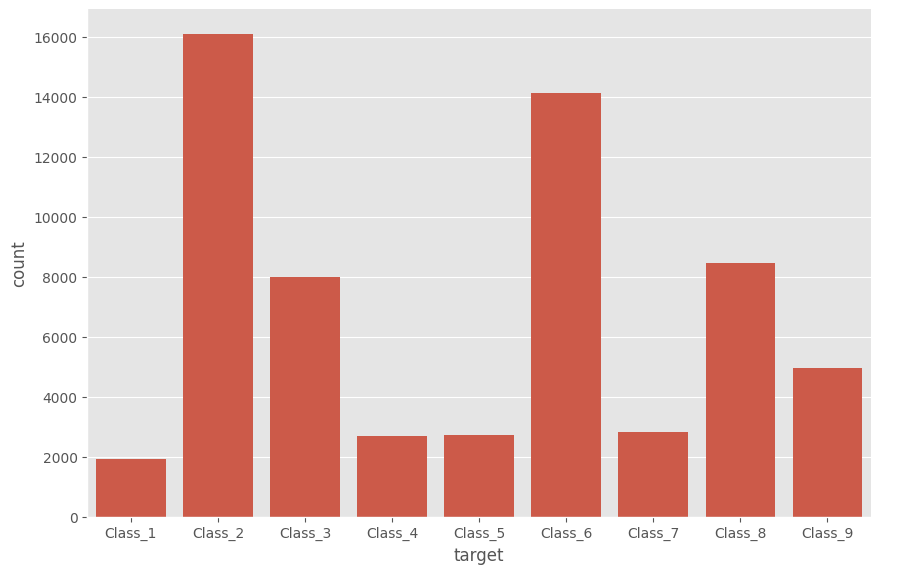

In [9]:
g = sns.catplot(x='target',data=df_train,kind="count")
g.figure.set_size_inches(10,6)
# df_train['target'].value_counts()

In [10]:
df_test.head()

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18,feat_19,feat_20,feat_21,feat_22,feat_23,feat_24,feat_25,feat_26,feat_27,feat_28,feat_29,feat_30,feat_31,feat_32,feat_33,feat_34,feat_35,feat_36,feat_37,feat_38,feat_39,feat_40,feat_41,feat_42,feat_43,feat_44,feat_45,feat_46,feat_47,feat_48,feat_49,feat_50,feat_51,feat_52,feat_53,feat_54,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,feat_65,feat_66,feat_67,feat_68,feat_69,feat_70,feat_71,feat_72,feat_73,feat_74,feat_75,feat_76,feat_77,feat_78,feat_79,feat_80,feat_81,feat_82,feat_83,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93
0,1,0,0,0,0,0,0,0,0,0,3,0,0,0,3,2,1,0,0,0,0,0,0,0,5,3,1,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,11,1,20,0,0,0,0,0
1,2,2,2,14,16,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,0,2,0,4,0,4,0,0,0,0,2,0,0,0,8,0,0,0,0,0,0,0,0,2,0,4,0,4,0,0,0,0,0,24,0,0,0,0,0,0,0,0,0,6,8,0,0,0,0,0,0,0,0,0,0,0,2,0,0,4,0,2,0,0,0,0,0,0,4,0,0,2,0
2,3,0,1,12,1,0,0,0,0,0,0,7,1,0,0,0,7,0,2,0,0,0,4,0,0,0,1,1,2,0,0,0,0,0,0,1,0,0,2,0,0,0,1,0,1,0,4,0,2,3,0,0,0,0,10,1,0,2,0,0,1,6,1,1,0,0,1,1,1,2,0,0,2,0,0,0,0,0,0,0,6,0,2,0,0,0,0,0,2,0,0,0,0,1
3,4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,21,3,0,0,0,0,0,0,0,0,4,0,0,0,1,0,0,0,2,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,9,0,0,2,0,0,0,0,6,0,8,0,0,0,0,1,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0
4,5,1,0,0,1,0,0,1,2,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,4,0,5,16,0,0,0,0,0,0,1,0,0,0,0,0,0,0,9,0,0


Tanto en la base de datos de testeo como la de entrenamiento vemos que los valores son muy dispersos (sparse), con un elevado número de ceros.

In [11]:
np.unique(df_train[features].values.flatten(),return_counts=True)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 119, 121, 123, 125, 127, 130, 131, 132, 137, 139, 145, 148,
        149, 158, 160, 161, 165, 170, 171, 172, 180, 181, 231, 252, 253,
        263, 281, 283, 287, 311, 323, 325, 352]),
 array([4565838,  595789,  227816,  106951,   66006,   40568,   30343,
          22321,   17639,   13326,   11271,    8394,    7670,    5740,
     

Visualizamos en un *boxplot* cada feature según las clases de salida. En este caso, fijamos el limite superior a 15 para ver con más detenimiento los diagramas de cajas.

  0%|          | 0/2 [00:00<?, ?it/s]

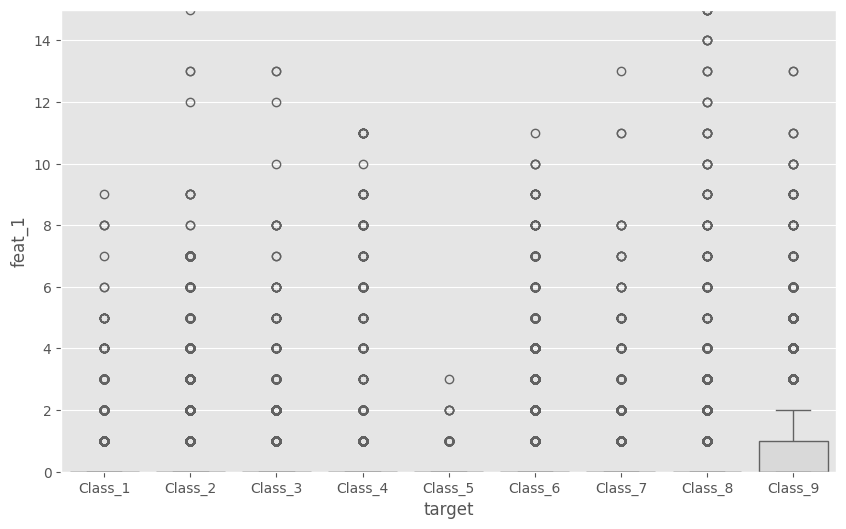

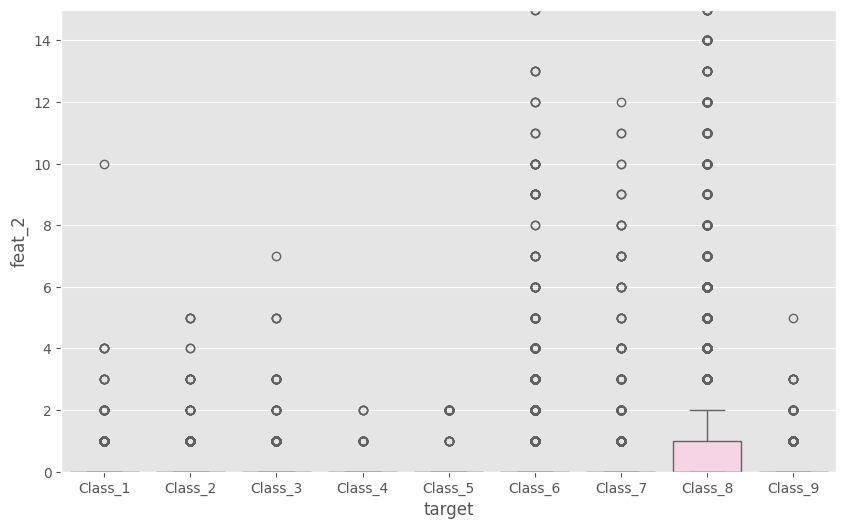

In [12]:
import warnings
warnings.filterwarnings('ignore')
num_vars = 2 #len(features) # max features len(features)
for name_feat in tqdm(features[:num_vars]):
    plt.figure(figsize=(10,6))
    ax = sns.boxplot(x='target', y=name_feat, palette='Set3', data=df_train)
    ax.set_ylim([0, 15])

## Preprocesado de la Base de Datos

Aunque a los árboles no les suele afectar en demasía que las variables tengan diferentes rangos, vamos a tipificar los datos con *Z-Score* por si vamos a usar otros algoritmos supervisados **basados en distancias**, como KNN, o no supervisados, como clústering.

In [13]:
# Estandarizamos las BD
scaler = StandardScaler()
X_train = df_train_reduc[features].values
X_valid = df_valid_reduc[features].values
X_test = df_test_reduc[features].values
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

# Obtenemos los targets
y_train = df_train_reduc['target_num'].values
y_valid = df_valid_reduc['target_num'].values
y_test = df_test_reduc['target_num'].values

In [14]:
print("Verificamos que las TARGETS estan estratificadas")
print(np.round(np.bincount(y_train)/len(y_train),3))
print(np.round(np.bincount(y_valid)/len(y_valid),3))
print(np.round(np.bincount(y_test)/len(y_test),3))

Verificamos que las TARGETS estan estratificadas
[0.031 0.261 0.129 0.043 0.044 0.228 0.046 0.137 0.08 ]
[0.031 0.261 0.129 0.044 0.044 0.228 0.046 0.137 0.08 ]
[0.031 0.261 0.129 0.043 0.044 0.229 0.046 0.137 0.08 ]


## Modelos Binarios de la Clase 2. Ejemplo con Random Forest

Vamos a desarrollar modelos clasificadores binarios de la clase 2 (Class_2) frente a las otras clases existentes. Para ello, creamos una clase binaria resultado de combinar todas las clases que no son de la clase 2 como 0, y 1 si pertenecen a la clase 2.

In [15]:
y_train_class2 = np.zeros_like(y_train.copy(), dtype=int)
# La clase 2 tiene el valor 1
y_train_class2[y_train==1] = 1
y_valid_class2 = np.zeros_like(y_valid.copy(), dtype=int)
y_valid_class2[y_valid==1] = 1
y_test_class2 = np.zeros_like(y_test.copy(), dtype=int)
y_test_class2[y_test==1] = 1

print('Porcentaje en las tres BD')
print(np.round(np.bincount(y_train_class2)/len(y_train_class2),3))
print(np.round(np.bincount(y_valid_class2)/len(y_valid_class2),3))
print(np.round(np.bincount(y_test_class2)/len(y_test_class2),3))

Porcentaje en las tres BD
[0.739 0.261]
[0.739 0.261]
[0.739 0.261]


### Métrica LogLoss

Inicialmente, vamos a buscar a hacer una exploración rápida con el algoritmo RandomForest que optimice el **logloss()**.

Esta métrica es una de las métricas más usadas en clasificación.

En clasificación multiclase o multilabel, se define como:

![](https://i.stack.imgur.com/NEmt7.png)

donde
- *N* = número de instancias.
- *M* = número de clases.
- $y_{ij}$ = probabilidad real de la clase $j$ correspondiente a la instancia $i$. Suele ser 1 o 0, aunque puede tener cualquier otro valor entre 0 y 1.
- $p_{ij}$ = probabilidad estimada por el clasificador para la clase $j$ de la instancia $i$.

Mientras que en clasificación binaria se suele usar:

![](https://miro.medium.com/max/656/1*wilGXrItaMAJmZNl6RJq9Q.png)

En ambos casos, cuanto más pequeño sea el valor de la métrica, mejor clasificación tendremos.

---

**Para profundizar, ver los siguiente videos**:

- *Understanding Binary Cross-Entropy / Log Loss in 5 minutes: a visual explanation*: https://www.youtube.com/watch?v=DPSXVJF5jIs
- *What is Log loss in machine learning|| How to calculate log loss in ML?*: https://www.youtube.com/watch?v=YbhzM2wxuBg

---

### Modelo RandomForest

Vamos a comenzar a estudiar **cómo modelizar el problema usando el algoritmo *RandomForestClassifier()* que es fácil de utilizar, potente y robusto**: . Más adelante, probaremos otros algoritmos más avanzados basados en Gradient Boosting Machines (GBM) como *LightGBM* o *XGBoost*.




---

**Para profundizar ver los siguiente videos**:

- *Random Forest Algorithm Clearly Explained!*: https://www.youtube.com/watch?v=v6VJ2RO66Ag
- *Random Forest Classification | Machine Learning | Python*: https://www.youtube.com/watch?v=3NdH3egUjpM
- *StatQuest: Random Forests Part 1 - Building, Using and Evaluating*: https://www.youtube.com/watch?v=J4Wdy0Wc_xQ
- *StatQuest: Random Forests Part 2: Missing data and clustering*: https://www.youtube.com/watch?v=sQ870aTKqiM

---



  0%|          | 0/9 [00:00<?, ?it/s]

<Axes: xlabel='n_estimators'>

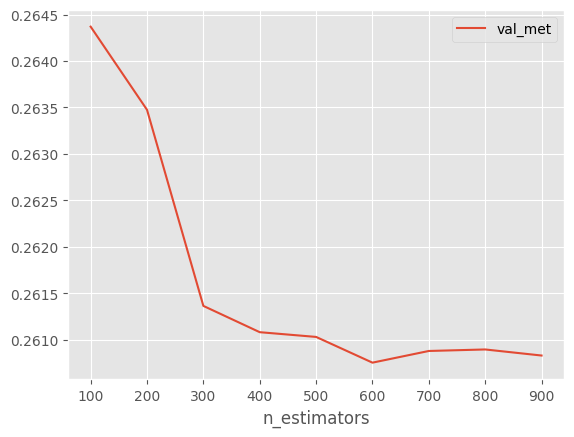

In [16]:
res = []
for n_estimators in tqdm(np.arange(100, 1000, 100)):
    rf_model = RandomForestClassifier(n_estimators=n_estimators, n_jobs=-1, random_state=4567)
    rf_model.fit(X_train_scaled, y_train_class2)
    val_met = log_loss(y_valid_class2, rf_model.predict_proba(X_valid_scaled)[:,1])
    res.append(dict(n_estimators=n_estimators, val_met=val_met))
res = pd.DataFrame(res)
res.plot(x='n_estimators', y='val_met')

In [17]:
print(res)

   n_estimators   val_met
0           100  0.264370
1           200  0.263475
2           300  0.261365
3           400  0.261082
4           500  0.261031
5           600  0.260754
6           700  0.260880
7           800  0.260896
8           900  0.260831


In [18]:
# Elegimos el numero de arboles que minimiza el log_loss
best_model = res.iloc[res.val_met.argmin()]
print(best_model)
best_estimators = best_model.n_estimators.astype(int)

# Logloss con la de testeo
rf_model = RandomForestClassifier(n_estimators=best_estimators, n_jobs=-1, random_state=4567)
rf_model.fit(X_train_scaled, y_train_class2)
tst_met = log_loss(y_test_class2, rf_model.predict_proba(X_test_scaled)[:,1])
print("Logloss con la base de datos de testeo=", tst_met)

n_estimators    600.000000
val_met           0.260754
Name: 5, dtype: float64
Logloss con la base de datos de testeo= 0.26022590420620706


### Calibrado de las Probabilidades

Así mismo, podemos ver la diferencia de calibrar las predicciones del clasificador o no. Muchos algoritmos no presentan una probabilidad equilibrada y **cuando se usan métricas del tipo *LogLoss*, es necesario equilibrar la probabilidad de las predicciones**.

Por ejemplo, si agrupamos los casos en los que el modelo estima una probabilidad cercana al 80%, el 80% de los targets deberían ser 1.0. Es decir, un modelo calibrado tendrá la misma proporción $\hat{p}$ de targets positivos en aquellas instancias clasificadas con una probabilidad cercana estimada $\hat{p}$.

Sin embargo, muchos algoritmos que no son probabilisticos como, por ejemplo, los árboles o las máquinas vectores soporte, realizan unas estimaciones de probabilidad que no están equilibradas.

*scikit-learn* dispone de la función *CalibratedClassifierCV()* que permite calcular un modelo y posteriormente [calibrar las probalidades](https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html#sphx-glr-auto-examples-calibration-plot-calibration-curve-py) con [regresión isotónica](https://en.wikipedia.org/wiki/Isotonic_regression) o regresión logística.

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_calibration_curve_002.png)

---

**Para profundizar ver los siguiente videos**:

- *Probability Calibration : Data Science Concepts*: https://www.youtube.com/watch?v=AunotauS5yI
- *Probability Calibration for Classification (Platt, isotonic, logistic and beta)*: https://www.youtube.com/watch?v=O5undKIazqs
- *Probability Calibration Workshop - Lesson 1*: https://www.youtube.com/watch?v=QUXfYgGlwtU

---

In [19]:
def entrena_model_hold_out(model, X_train, y_train, X_valid, y_valid, calibra=True):
    np.random.seed(4567)
    if calibra:
        calibrated_clf = CalibratedClassifierCV(model, method='isotonic', cv=5)
        calibrated_clf.fit(X_train, y_train)
        preds = calibrated_clf.predict_proba(X_valid)[:,1]
    else:
        model.fit(X_train, y_train)
        preds = model.predict_proba(X_valid)[:,1]

    preds_bin = preds >= 0.50
    metrica_log_loss = log_loss(y_valid, preds, normalize=True)
    metrica_acc = accuracy_score(y_valid, preds_bin)
    metrica_kappa = cohen_kappa_score(y_valid, preds_bin)
    metrica_auc = roc_auc_score(y_valid, preds)
    metrica_f1 = f1_score(y_valid, preds_bin)

    print(f'n_estimators={model.n_estimators}, Calibrado={calibra}\n'
          f'ACC={metrica_acc}, F1={metrica_f1}, Kappa={metrica_kappa}\n'
          f'AUC={metrica_auc}, LogLoss={metrica_log_loss}')

    return dict(n_estimators=model.n_estimators, calibrado=calibra,
                log_loss=metrica_log_loss, acc=metrica_acc, kappa=metrica_kappa,
                auc=metrica_auc, f1=metrica_f1)


In [20]:
%%time
# Comprobamos el grado de generalización del modelo con y sin calibración
rf_model = RandomForestClassifier(n_estimators=best_estimators, n_jobs=-1, random_state=4567)
metricas = entrena_model_hold_out(rf_model, X_train_scaled, y_train_class2, X_test_scaled, y_test_class2, calibra=False)
print(f'Modelo Sin Calibrar LogLossVal={metricas["log_loss"]}')

metricas = entrena_model_hold_out(rf_model, X_train_scaled, y_train_class2, X_test_scaled, y_test_class2, calibra=True)
print(f'Modelo Con Calibración LogLossVal={metricas["log_loss"]}')

n_estimators=600, Calibrado=False
ACC=0.8835254821678699, F1=0.7726125368111064, Kappa=0.694356663866621
AUC=0.9517928249645172, LogLoss=0.26022590420620706
Modelo Sin Calibrar LogLossVal=0.26022590420620706
n_estimators=600, Calibrado=True
ACC=0.8788384872319793, F1=0.7825582519578459, Kappa=0.6990670430114758
AUC=0.9499925249848146, LogLoss=0.25004736815763234
Modelo Con Calibración LogLossVal=0.25004736815763234
CPU times: user 3min 31s, sys: 2.99 s, total: 3min 34s
Wall time: 2min 4s


### EJERCICIO 3.A.1

Realizar las tareas siguientes y responder en un Informe PDF a las respuestas planteadas:

- Buscar el mejor modelo RF modificando *n_estimators* entre 100 y 1500 (con paso 100) que optimice las siguientes cinco métricas con la base de datos de validación: *Accuracy*, *F1-Score*, *Kappa*, *AUC* y *logloss*. Probar para cada métrica *sin calibrar* y *calibrando*.
- Rellenar **la tabla de abajo con el mejor número de estimadores (calibrando o sin calibrar)** y para cada una de las métricas (presentar el resultado para la base de datos de validación y la de testeo).
- Analizar la tabla y explicar los resultados.
- Explicar **el significado de cada métrica** y analizar por qué funciona mejor un método u otro para cada una de ellas.
- Pon ejemplos de la vida real de cuándo utilizar una métrica u otra.
- **Incluir en el informe PDF la tabla y el código usado para generarla.**

NOTA: Utilizar la misma semilla aleatoria usada en los ejemplos. Pregunta: ¿Qué pasa si cambiamos la semilla aleatoria?  

    
| Métrica | *n_estimators* | Calibrado | Val | Tst |
|---------|-----------|-----------|-----|-----|
| ACC |100|Si|0.00|0.05|
| F1  |200|No|0.00|0.05|
| Kappa |150|Si|0.00|0.05|
| AUC   |200|No|0.00|0.05|
| LogLoss |250|Si|0.00|0.05|


In [21]:
results_calibrado = []
results_no_calibrado = []

for n_estimators in tqdm(np.arange(100, 1500, 100)):
    rf_modelo = RandomForestClassifier(n_estimators=n_estimators, n_jobs=-1,
                                       random_state=4567)
    metricas_calibrado = entrena_model_hold_out(rf_modelo, X_train_scaled,
                                                y_train_class2, X_test_scaled,
                                                y_test_class2, calibra=True)
    results_calibrado.append(metricas_calibrado)
    metricas_no_calibrado = entrena_model_hold_out(rf_modelo, X_train_scaled,
                                                   y_train_class2, X_test_scaled,
                                                   y_test_class2, calibra=False)
    results_no_calibrado.append(metricas_no_calibrado)

results_calibrado = pd.DataFrame(results_calibrado)
results_no_calibrado = pd.DataFrame(results_no_calibrado)

  0%|          | 0/14 [00:00<?, ?it/s]

n_estimators=100, Calibrado=True
ACC=0.8788923607369895, F1=0.7811952501459997, Kappa=0.6978651487291327
AUC=0.9495782246217586, LogLoss=0.25160591952347766
n_estimators=100, Calibrado=False
ACC=0.8825018855726754, F1=0.771885786005648, Kappa=0.6927728560267894
AUC=0.9501879297898371, LogLoss=0.2617791651101773
n_estimators=200, Calibrado=True
ACC=0.8792156017670509, F1=0.7812682926829269, Kappa=0.6982054291138242
AUC=0.9498082743334338, LogLoss=0.2503156759277254
n_estimators=200, Calibrado=False
ACC=0.8842258377330029, F1=0.774808760347899, Kappa=0.6969125650147333
AUC=0.9513579937285188, LogLoss=0.2605715017764413
n_estimators=300, Calibrado=True
ACC=0.8787307402219589, F1=0.7817317948220692, Kappa=0.6982193690802914
AUC=0.9500155412532343, LogLoss=0.2498823516881338
n_estimators=300, Calibrado=False
ACC=0.8836871026829005, F1=0.7734760256006715, Kappa=0.695255239080262
AUC=0.9516638103447431, LogLoss=0.2603544609285885
n_estimators=400, Calibrado=True
ACC=0.87900010774701, F1=0.782

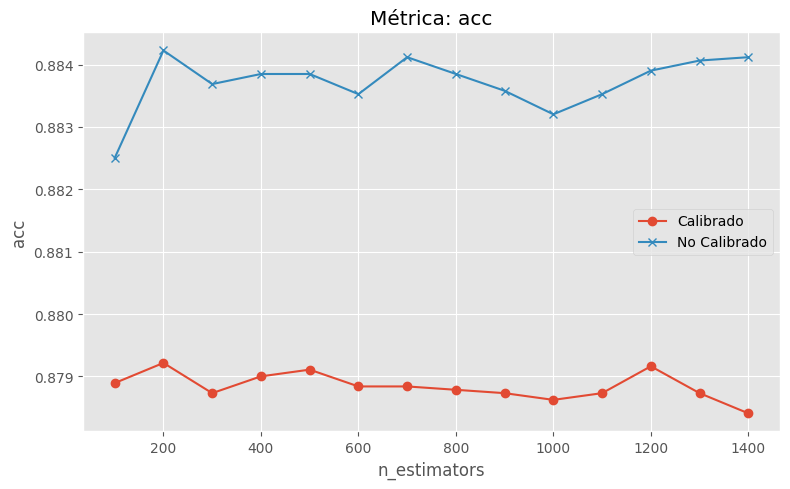

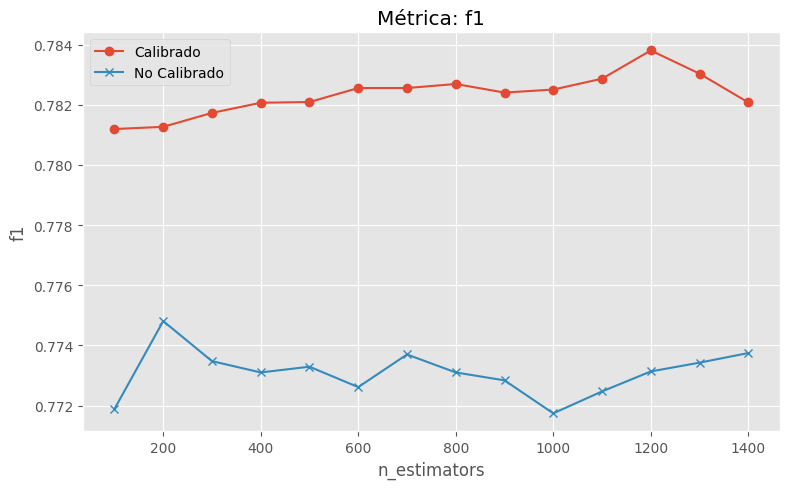

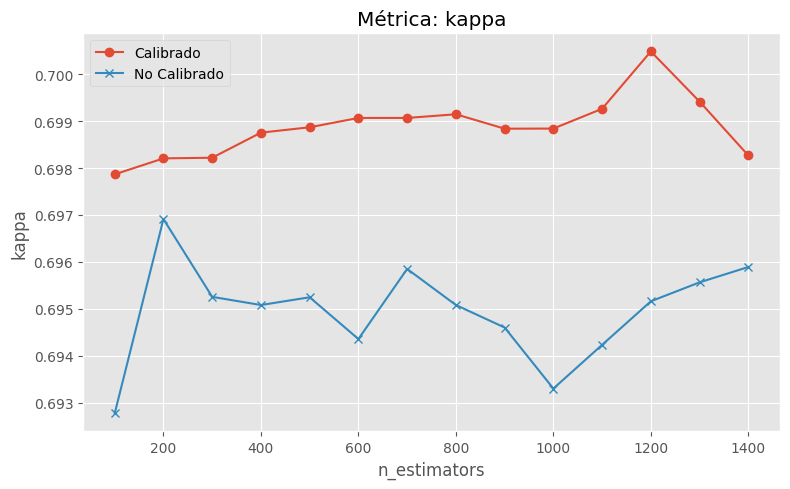

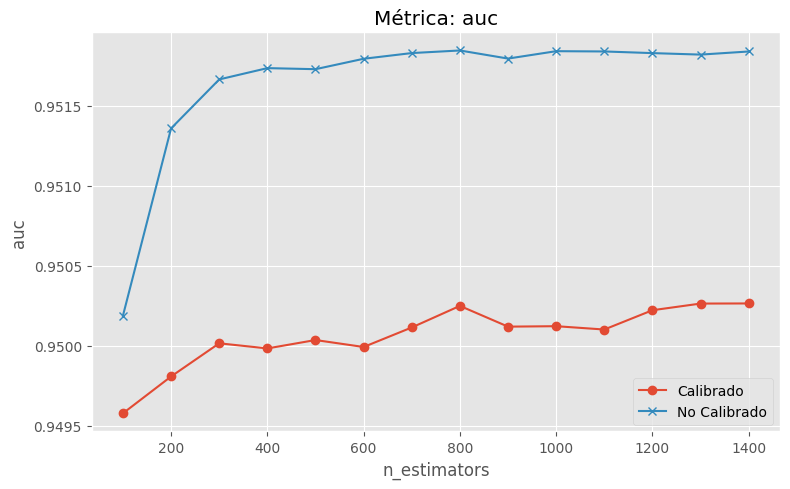

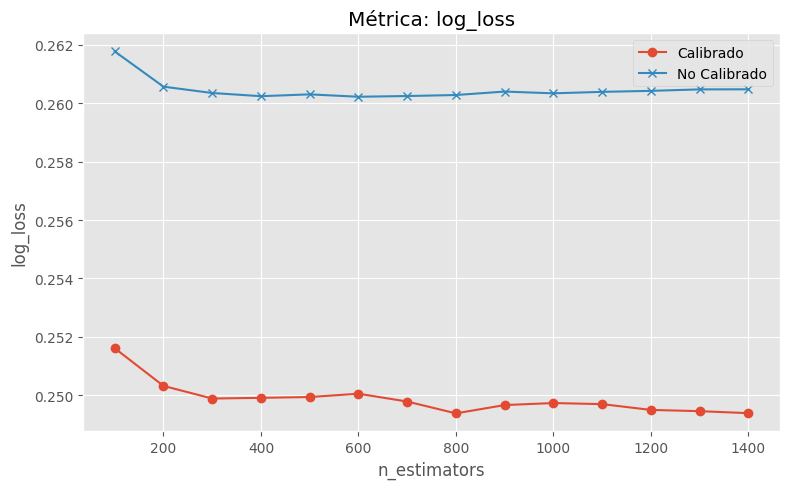

In [22]:
metricas = ['acc', 'f1', 'kappa', 'auc', 'log_loss']
for metrica in metricas:
    plt.figure(figsize=(8, 5))
    plt.plot(results_calibrado['n_estimators'], results_calibrado[metrica],
             label='Calibrado', marker='o')
    plt.plot(results_no_calibrado['n_estimators'], results_no_calibrado[metrica],
             label='No Calibrado', marker='x')
    plt.xlabel('n_estimators')
    plt.ylabel(metrica)
    plt.title(f'Métrica: {metrica}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [23]:
# Función generalizada para evaluación
def evaluar_modelo(n_estimators, calibrado, X_train, y_train, X_eval, y_eval):
    modelo = RandomForestClassifier(n_estimators=n_estimators, n_jobs=-1, random_state=4567)
    if calibrado:
        modelo = CalibratedClassifierCV(modelo, method='isotonic', cv=5)
    modelo.fit(X_train, y_train)
    probs = modelo.predict_proba(X_eval)[:, 1]
    return {
        'acc': accuracy_score(y_eval, probs > 0.5),
        'f1': f1_score(y_eval, probs > 0.5),
        'kappa': cohen_kappa_score(y_eval, probs > 0.5),
        'auc': roc_auc_score(y_eval, probs),
        'log_loss': log_loss(y_eval, probs)
    }

In [24]:
# Concatenamos resultados previos
df_resultados = pd.concat([results_calibrado, results_no_calibrado], ignore_index=True)

# Crear tabla resumen bien calculada
resumen = []
for metrica in ['acc', 'f1', 'kappa', 'auc', 'log_loss']:
    mejor = df_resultados.loc[df_resultados[metrica].idxmin() if metrica == 'log_loss' else df_resultados[metrica].idxmax()]

    n_est = int(mejor['n_estimators'])
    calib = bool(mejor['calibrado'])

    # Calcular sobre validación
    val_scores = evaluar_modelo(n_est, calib, X_train_scaled, y_train_class2, X_valid_scaled, y_valid_class2)

    # Calcular sobre test
    test_scores = evaluar_modelo(n_est, calib, X_train_scaled, y_train_class2, X_test_scaled, y_test_class2)

    resumen.append({
        'Métrica': metrica.upper(),
        'n_estimators': n_est,
        'Calibrado': 'Sí' if calib else 'No',
        'Val': round(val_scores[metrica], 4),
        'Tst': round(test_scores[metrica], 4)
    })

# Mostrar tabla
tabla_final = pd.DataFrame(resumen)
tabla_final


,Métrica,n_estimators,Calibrado,Val,Tst
0,ACC,200,No,0.8836,0.8841
1,F1,1200,Sí,0.7858,0.7838
2,KAPPA,1200,Sí,0.7039,0.7005
3,AUC,800,No,0.9514,0.9518
4,LOG_LOSS,800,Sí,0.2527,0.2494


### EJERCICIO 3.A.2

Repetir el ejercicio anterior pero usando otros algoritmos (tocando solo el hiperparámetro más importante del algoritmo):
- LogisticRegression(*C* = cost)
- KNeighborsClassifier(*n_neighbors* = num_vecinos)
- MLPClassifier(*hidden_layer_sizes* = (num_neuronas,), *solver* = 'lbfgs')
- DecisionTreeClassifier(*max_depth* = max_profundidad)
- SVC(*C*= cost, *kernel*='rbf')


**Rellenar una tabla indicando para cada algoritmo el valor obtenido de la métrica y si ha sido conveniente calibrar o no (entre parentesis). No incluir el RF pues posiblemente ganará a todos al ser un modelo ensemble**

| Métrica | LOG | KNN | MLP | DTC | SVC |
|---------|-----|-----|-----|----|-----|
| ACC     |0.00(si)|0.00(si)|0.00(si)|0.00(no)|0.00(no)|
| F1     |0.00(si)|0.00(si)|0.00(si)|0.00(no)|0.00(no)|
| Kappa     |0.00(si)|0.00(si)|0.00(si)|0.00(no)|0.00(no)|
| AUC     |0.00(si)|0.00(si)|0.00(si)|0.00(no)|0.00(no)|
| LogLoss     |0.00(si)|0.00(si)|0.00(si)|0.00(no)|0.00(no)|


Analiza la tabla y extrae tus propias conclusiones.



In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [32]:
# Diccionario para almacenar los modelos y sus parámetros
modelos = {
    "LOG": {"modelo": LogisticRegression, "param": "C", "valores": [0.01, 0.1, 1, 10, 100]},
    "KNN": {"modelo": KNeighborsClassifier, "param": "n_neighbors", "valores": [3, 5, 7, 9, 11]},
    "MLP": {"modelo": MLPClassifier, "param": "hidden_layer_sizes", "valores": [(5,), (10,), (20,), (50,), (100,)]},
    "DTC": {"modelo": DecisionTreeClassifier, "param": "max_depth", "valores": [3, 5, 10, 15, 20]},
    "SVC": {"modelo": SVC, "param": "C", "valores": [0.1, 1, 10, 100]},
}

# Métricas
metricas = ['acc', 'f1', 'kappa', 'auc', 'log_loss']

# Resultados
tabla_resultados = {metrica.upper(): {} for metrica in metricas}

# Evaluación para cada modelo
for nombre, info in modelos.items():
    mejor_resultado = {metrica: -np.inf if metrica != 'log_loss' else np.inf for metrica in metricas}
    mejor_config = {metrica: {} for metrica in metricas}

    for valor in info["valores"]:
        kwargs = {info["param"]: valor}
        model = info["modelo"](**kwargs)

        for calibra in [True, False]:
            try:
                if calibra:
                    clf = CalibratedClassifierCV(model, method='isotonic', cv=5)
                else:
                    clf = model
                clf.fit(X_train_scaled, y_train_class2)
                probs = clf.predict_proba(X_valid_scaled)[:, 1]
                preds = probs >= 0.5

                resultados = {
                    'acc': accuracy_score(y_valid_class2, preds),
                    'f1': f1_score(y_valid_class2, preds),
                    'kappa': cohen_kappa_score(y_valid_class2, preds),
                    'auc': roc_auc_score(y_valid_class2, probs),
                    'log_loss': log_loss(y_valid_class2, probs)
                }

                for metrica in metricas:
                    actual = resultados[metrica]
                    mejor = mejor_resultado[metrica]
                    if (metrica == 'log_loss' and actual < mejor) or (metrica != 'log_loss' and actual > mejor):
                        mejor_resultado[metrica] = actual
                        mejor_config[metrica] = {
                            'valor': round(actual, 4),
                            'calibra': calibra
                        }
            except Exception as e:
                continue

    # Guardamos en tabla_resultados
    for metrica in metricas:
        val = mejor_config[metrica]['valor']
        calibra = mejor_config[metrica]['calibra']
        tabla_resultados[metrica.upper()][nombre] = f"{val}({'sí' if calibra else 'no'})"

# Convertimos a DataFrame final
tabla_final = pd.DataFrame(tabla_resultados)

KeyError: "None of [Index(['LOG', 'KNN', 'MLP', 'DTC', 'SVC'], dtype='object')] are in the [columns]"

In [33]:
tabla_final

,ACC,F1,KAPPA,AUC,LOG_LOSS
LOG,0.8392(no),0.7291(sí),0.6166(sí),0.9099(sí),0.3232(no)
KNN,0.8558(no),0.7428(sí),0.6396(sí),0.931(sí),0.2923(sí)
MLP,0.8679(no),0.7692(sí),0.6716(sí),0.9449(sí),0.2783(sí)
DTC,0.8568(sí),0.7213(sí),0.6192(sí),0.9191(sí),0.3308(sí)
SVC,0.8699(sí),0.7662(sí),0.6765(sí),0.9383(sí),0.2855(sí)


## Balanceo de Clases

Algunas métricas pueden mejorarse mediante el balanceo de las clases que consiste en **equilibrar el número de casos de cada clase**:

- Sobremuestreando la clase minoritaria (*oversampling*).
- Submuestrando la clase mayoritaria (*subsampling*).
- Creando nuevos casos de la clase minoritaria mediante algoritmos como SMOTE.

Ver: https://www.kaggle.com/code/residentmario/undersampling-and-oversampling-imbalanced-data/notebook

Otra forma, más habitual y eficiente, **es aplicar diferentes pesos a cada una de las clases**, de forma que la clase minoritaria tenga mayor peso que la mayoritaria a la hora de construir el modelo (habitualmente la función *loss* del algoritmo incorpora los pesos de cada clase en la propia fórmula de modo que el balanceo se realiza directamente al calcular dicho coste).

Vamos a ver un ejemplo para mejora el *accuracy*. Como se puede ver en la gráfica, la base de datos está desbalanceada.

,count
is_class_2,
False,18303
True,6449


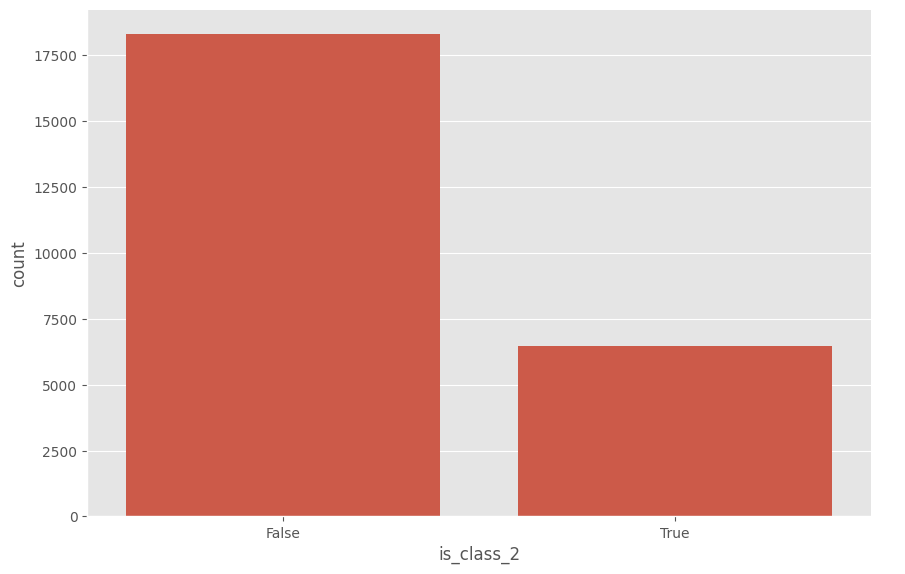

In [34]:
X_tmp = df_train_reduc.copy()
X_tmp['is_class_2'] = (y_train_class2==1)
g = sns.catplot(x='is_class_2', data=X_tmp, kind='count')
g.figure.set_size_inches(10,6)
X_tmp['is_class_2'].value_counts()

In [35]:
def entrena_model_hold_out(model, X_train, y_train, X_valid, y_valid, calibra=True):
    np.random.seed(4567)
    if calibra:
        calibrated_clf = CalibratedClassifierCV(model, method='isotonic', cv=5)
        calibrated_clf.fit(X_train, y_train_class2)
        preds = calibrated_clf.predict_proba(X_valid)[:,1]
    else:
        model.fit(X_train, y_train)
        preds = model.predict_proba(X_valid)[:,1]
    metrica_log_loss = log_loss(y_valid, preds, normalize=True)
    metrica_acc = accuracy_score(y_valid, preds>0.50)
    return dict(log_loss=metrica_log_loss, acc=metrica_acc)

Vamos a probar Balancear las clases con la librería *imblearn* usando el modelo Logistico.

**Es importante entender que la base de datos de validación y testeo NO hay que modificarlas, solo la de entrenamiento. Si modificamos las bases de datos de validación o testeo estamos desvirtuando toda la validación de los modelos**

In [36]:
!python -m pip install imblearn

In [37]:
log_model = LogisticRegression(C=1, random_state=1234, n_jobs=-1)
metricas = entrena_model_hold_out(log_model, X_train_scaled, y_train_class2, X_valid_scaled, y_valid_class2, calibra=False)
print(f'Modelo Logistico Sin Balancear ACC={metricas["acc"]}')

Modelo Logistico Sin Balancear ACC=0.839151045033398


Probamos con Oversampling

In [38]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
oversamp = RandomOverSampler(random_state=1234)
X_train_resampled, y_train_resampled = oversamp.fit_resample(X_train_scaled, y_train_class2)
print('Numero de casos de cada clase:', np.bincount(y_train_resampled))

log_model = LogisticRegression(C=1, random_state=1234, n_jobs=-1)
metricas = entrena_model_hold_out(log_model, X_train_resampled, y_train_resampled, X_valid_scaled, y_valid_class2, calibra=False)
print(f'Modelo Logistico con OverSampling ACC={metricas["acc"]}')

Numero de casos de cada clase: [18303 18303]
Modelo Logistico con OverSampling ACC=0.8198125404007757


Probamos con Undersampling

In [39]:
oversamp = RandomUnderSampler(random_state=1234)
X_train_resampled, y_train_resampled = oversamp.fit_resample(X_train_scaled, y_train_class2)
print('Numero de casos de cada clase:', np.bincount(y_train_resampled))

log_model = LogisticRegression(C=1, random_state=1234, n_jobs=-1)
metricas = entrena_model_hold_out(log_model, X_train_resampled, y_train_resampled, X_valid_scaled, y_valid_class2, calibra=False)
print(f'Modelo Logistico con UnderSampling ACC={metricas["acc"]}')

Numero de casos de cada clase: [6449 6449]
Modelo Logistico con UnderSampling ACC=0.818304244774833


Vemos que parece que NO mejora el ACC con ninguno de los dos. **Quizás balancear al 100% las clases es demasiado y puede ser interesante hacer un balanceo con un ratio que no sea del 100%. Para ello se puede usar la opción *sampling_strategy* que permite indicar el número de casos de cada clase que queremos que muestree**.

Incrementamos levemente el número de casos de la clase 2 (clase minoritaria)

In [40]:
# Distribución original de las clases del target
print(np.unique(y_train_class2, return_counts=True))

(array([0, 1]), array([18303,  6449]))


Incrementamos con Oversampling la clase minoritaria a 6500 y vemos que mejora un poco el ACC.

In [41]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
oversamp = RandomOverSampler(random_state=1234, sampling_strategy={0:18303, 1:6500})
X_train_resampled, y_train_resampled = oversamp.fit_resample(X_train_scaled, y_train_class2)
print('Numero de casos de cada clase:', np.bincount(y_train_resampled))

log_model = LogisticRegression(C=1, random_state=1234, n_jobs=-1)
metricas = entrena_model_hold_out(log_model, X_train_resampled, y_train_resampled, X_valid_scaled, y_valid_class2, calibra=False)
print(f'Modelo Logistico con un ligero OverSampling ACC={metricas["acc"]}')

Numero de casos de cada clase: [18303  6500]
Modelo Logistico con un ligero OverSampling ACC=0.8393126481361776


Existen otros métodos como SMOTE que permite realizar nuevas instancias de la clase minoritaria en base a búsqueda por K-Vecinos (ver ejemplos en https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/).


Otra forma, muy utilizada e incluso más eficiente, es la del siguiente ejemplo donde vemos otra forma de tratar el desbalanceo mediante el uso de pesos diferentes para cada clase.        

In [42]:
%%time
# Se asigna un peso a cada clase inversamente proporcional a la fecuencia de cada clase
print('Pesos asignados por defecto a cada clase:',len(y_train_class2)/(2*np.bincount(y_train_class2)))
log_model = LogisticRegression(C=1, class_weight='balanced',random_state=4567,n_jobs=-1)
metricas = entrena_model_hold_out(log_model, X_train_resampled, y_train_resampled, X_valid_scaled, y_valid_class2, calibra=False)
print(f'Modelo Logistico ajustando los Pesos ACC={metricas["acc"]}')

Pesos asignados por defecto a cada clase: [0.6761733  1.91905722]
Modelo Logistico ajustando los Pesos ACC=0.8197048049989226
CPU times: user 60.8 ms, sys: 12 ms, total: 72.8 ms
Wall time: 1.56 s


Igual que en el caso anterior, los pesos pueden ser ajustados manualmente para que el balanceo sea menos drástico. En este caso ajustamos el peso de la clase minoritaria dándole un poco más de peso que la mayoritaria (0.7 vs 0.6761). Vemos que el ACC mejora...

In [43]:
%%time
# Ajustamos el peso de la clase minoritaria
log_model = LogisticRegression(C=1, class_weight={0:0.6761, 1:0.7}, random_state=4567,n_jobs=-1)
metricas = entrena_model_hold_out(log_model, X_train_resampled, y_train_resampled, X_valid_scaled, y_valid_class2, calibra=False)
print(f'Modelo Logistico ajustando los Pesos ACC={metricas["acc"]}')

Modelo Logistico ajustando los Pesos ACC=0.8394203835380306
CPU times: user 64.4 ms, sys: 18 ms, total: 82.4 ms
Wall time: 1.89 s


### EJERCICIO  3.A.3

Elige el mejor algoritmo para cada una de las métricas obtenidas en la tabla del ejercicio 2 e intenta mejorar los resultados obtenidos con Undersampling o Oversampling. **Probar diversos distribuciones o pesos para las clases intentando mejorar cada métrica según el algoritmo que dio mejor resultado en el punto 3.A.2.**.

Rellena la siguiente tabla con los resultados obtenidos.



| Métrica | Algoritmo | Original | Nuevo | Método Usado |
|---------|-----------|----------|-------|--------------|
| ACC     |MLP|0.00|0.05|Undersampling (0=10000,1=7000)|
| F1     |SVC|0.00|0.05|No se ha podido|
| Kappa     |LOG|0.00|0.05|Undersampling (0=10000,1=7000)|
| AUC     |DTC|0.00|0.05|Oversampling (0=10500,1=6500)|
| LogLoss     |MLP|0.00|0.05|No se ha podido|

In [44]:
def evaluar_balanceo(modelo, X_train, y_train, X_valid, y_valid, metodo=None, strategy=None, calibrado=True):
    if metodo == 'undersample':
        sampler = RandomUnderSampler(sampling_strategy=strategy, random_state=42)
    elif metodo == 'oversample':
        sampler = RandomOverSampler(sampling_strategy=strategy, random_state=42)
    else:
        sampler = None

    if sampler:
        X_train, y_train = sampler.fit_resample(X_train, y_train)

    if calibrado:
        modelo = CalibratedClassifierCV(modelo, method='isotonic', cv=5)

    modelo.fit(X_train, y_train)
    probs = modelo.predict_proba(X_valid)[:, 1]
    preds = probs >= 0.5

    return {
        'acc': round(accuracy_score(y_valid, preds), 4),
        'f1': round(f1_score(y_valid, preds), 4),
        'kappa': round(cohen_kappa_score(y_valid, preds), 4),
        'auc': round(roc_auc_score(y_valid, probs), 4),
        'log_loss': round(log_loss(y_valid, probs), 4)
    }

## ENTREGA

**Todos los pasos realizados deberán ser explicados con detalle en un documento PDF. El nombre del archivo deberá incluir lo siguiente 'PROYECTO3_NombreDelAlumnoSinAcentos.PDF'. Ejemplo: PROYECTO3A_PEPITO_PEREZ.PDF**

Si usas Colab, recuerde guardar sus cambios en su repositorio utilizando la opción "Save a copy in GitHub..." del menú File.